# Diagnostics and Comparison (C2ST)

## SBC

In [2]:
import torch

from torch import eye, ones, zeros

import numpy as np
from scipy.integrate import odeint
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import random
import time

import sbi

from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot
from sbi.inference import SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

/Users/E_V_/Documents/Uni/PostGrad/Project_1/sbi_env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#true_params = 0., 0.       # if this changes, model must also be adjusted
prior_min = -3
prior_max = 3
num_timesteps = 100
num_simulations = 1000   # how many simulations in each round

In [5]:
def repressilator(variables, t, theta):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = theta
    return [-m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 10 ** 0, #return the results if the six odes
            -10 ** 0 * (p1 - m1),
            -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 10 ** 0,
            -10 ** 0 * (p2 - m2),
            -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 10 ** 0,
            -10 ** 0 * (p3 - m3)]

In [6]:
t = np.linspace(0, 100, num_timesteps)
def my_simulator(theta):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    solution = odeint(repressilator, initial_conditions, t, args=(theta,))
    return torch.tensor(solution, dtype=torch.float32).flatten()  # Flat
num_dim = 2
prior = utils.BoxUniform(low=prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))
inference = SNRE(prior=prior)
simulator, prior = prepare_for_sbi(my_simulator, prior) 

In [7]:
posteriors = []
theta, x = simulate_for_sbi(simulator, prior, num_simulations=1000)
# In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
density_estimator = inference.append_simulations(
    theta, x
).train()
posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)

Running 1000 simulations.: 100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


 Neural network successfully converged after 69 epochs.

In [8]:
theta_o = prior.sample((1,))
x_o = simulator(theta_o)
print("theta:", theta_o.numpy())
print("x    :", x_o.numpy())

theta: [[2.5600452 1.6042233]]
x    : [[  0.           2.           0.           1.           0.
    3.           0.6457766    0.9999446    0.6401354    0.63595146
  248.25851     90.248764     0.88136154   0.8743084    0.86895746
    0.73504823 442.9172     269.87436      0.9642121    0.91388994
    0.9522798    0.85530543 515.2523     411.59006      0.99289846
    0.958053     0.98262304   0.9297513  525.52747    483.01422
    1.0027109    0.98437697   0.9936732    0.968025   518.0667
  507.57108      1.0060122    0.9974396    0.9976974    0.98602855
  509.51926    510.9662       1.0070974    1.0033537    0.999163
    0.99406546 503.69705    507.73724      1.0074425    1.005882
    0.99969673   0.9975315  500.3956     503.8385       1.0075473
    1.0069194    0.9998911    0.9989901  498.70068    500.96024
    1.0075766    1.0073314    0.9999619    0.9995928  497.88498
  499.18976      1.0075837    1.0074905    0.9999877    0.99983835
  497.51028    498.2061       1.0075849    1.00755

In [14]:
posterior_samples = posterior.sample((1_000,), x=x_o)
# Generate predictive samples by simulating from posterior samples.
posterior_predictive_samples = simulator(posterior_samples)

Generating samples: 100%|██████████| 10100/10100 [03:17<00:00, 51.06it/s]


In [15]:
# let's do some posterior predictive checks to see if the
# posterior predictive samples cluster aournd the observation `x_o`.
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_predictive_samples,
    points=x_o,
    limits=list(zip(x_o.flatten() - 1.0, x_o.flatten() + 1.0)),
    offdiag="kde",
    diag="kde",
    figsize=(5, 5),
    labels=[rf"$x_{d}$" for d in range(3)],
)

In [9]:
num_sbc_runs = 100  # choose a number of sbc runs, should be ~100s or ideally 1000
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_runs,))
xs = simulator(thetas)

In [10]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 100
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)


/Users/E_V_/Documents/Uni/PostGrad/Project_1/sbi_env1/lib/python3.11/site-packages/sbi/analysis/sbc.py:57: UserWarning: Number of SBC samples should be on the order of 100s to give realiable
            results. We recommend using 300.
  warnings.warn(
Running 100 sbc samples.: 100%|██████████| 100/100 [30:31<00:00, 18.32s/it]


In [11]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)
print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)


/Users/E_V_/Documents/Uni/PostGrad/Project_1/sbi_env1/lib/python3.11/site-packages/sbi/analysis/sbc.py:363: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  if (c2st_scores.std(0) > 0.05).any():


kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0.00263005 0.16496272]


The p values are for the null hypothesis that the samples from ranks are drawn from a uniform distribution (in other words H_0: PDF(ranks) == PDF(uniform)).
We have two parameters - one p-value for each dimension.

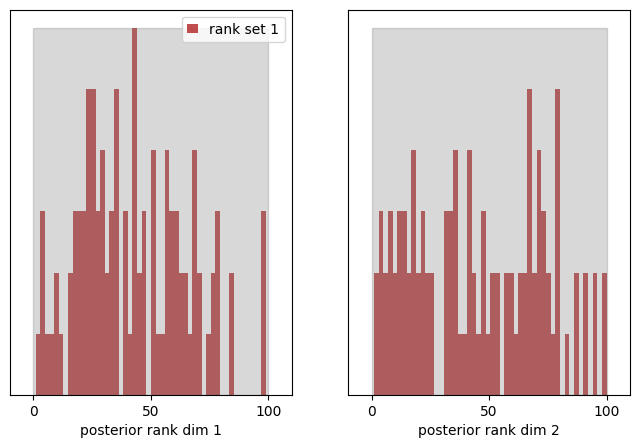

In [13]:
from sbi.analysis import sbc_rank_plot

f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=50,  # by passing None we use a heuristic for the number of bins.
)


Highlighted in grey you see the 99% confidence interval of a uniform distribution given the number of samples provided. I

This takes a long time - we will need either hpc or doing it on amortised model (no sequential stuff), that would take quite long!

## Comparing two results visually

e.g. We have posterior_samples from SNLE and NRE in np.array posterior_samples and posterior_samples sre

In [ ]:
import pandas as pd
import seaborn as sns
 

column_name = ['k1','k2']

snle_pos = pd.DataFrame(data=posterior_samples,columns=column_name)
snre_pos = pd.DataFrame(data=posterior_samples_sre, columns=column_name)

snle_pos['algorithm']="SNLE"
snre_pos["algorithm"]="SNRE"
df_joint = pd.concat([snle_pos, snre_pos])
g=sns.PairGrid(df_joint, diag_sharey=False, hue="algorithm")
g.map_diag(sns.kdeplot, fill=True, alpha=0.2)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot,s=3)
g.add_legend()
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1)
)

## C2ST


A classifier-based two sample test
A MLP model is used with 2 hidden layers, hyperparameters including learning rate and the number of nodes in each hidden layer.
Accuracy of classifier on test data is returned. Accuracy is considered a good metric for classifier performance as the data is balanced across the two groups.

at or below 0.5 meaning indistinguishable distribution

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import sklearn

In [ ]:
def c2st(
    X: torch.Tensor,
    Y: torch.Tensor,
    seed: int = 1,
    n_folds: int = 5
) -> torch.Tensor:
    """Classifier-based 2-sample test returning accuracy, modified from SBIBM

    Args:
        X: Sample 1
        Y: Sample 2
        seed: Seed for sklearn
        n_folds: Number of folds. Initially set to 5
       
    """
    ndim = X.shape[1]
    data = np.concatenate((X, Y))
    target = np.concatenate(
        (
            np.zeros((X.shape[0],)),
            np.ones((Y.shape[0],)),
        )
    )
    X_train, X_test, y_train, y_test=sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=None, shuffle=True)
    mlp = MLPClassifier(max_iter=10000)
    parameter_space = {
        'hidden_layer_sizes': [(ndim,ndim), (2*ndim,2*ndim)],
        'solver': ['adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
    shuffle = KFold(n_splits=5, shuffle=True, random_state=seed)
    clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=shuffle)
    clf.fit(X_train, y_train)
    #means = clf.cv_results_['mean_test_score']
    #stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    #print('Best parameters found:\n', clf.best_params_)
    y_pred=clf.predict(X_test)
    score=clf.score(X_test, y_test)
    return score

## Posterior predictive check (PPC)

In [ ]:
#trajectories quantile
raw_trajectories=np.zeros([100,100,6]) #first dim:no of samples, 100 time points, 6 trajec
for i in range(posterior_samples.shape[0]):
    raw_trajectories[i]=my_simulator(posterior_samples[i,:]).reshape(100,6)
tr=np.percentile(raw_trajectories, [2.5, 97.5], axis=0)

In [ ]:
import matplotlib.pyplot as plt
fig, ax=plt.subplots(2,3,figsize=(12,9))
ax = ax.ravel()
col=["blue","blue"]
titles=["m1","p1","m2","p2", "m3", "p3"]
for i in range(6):
    for j in range(2):
        ax[i].plot(tr[j,:,i],c=col[j],alpha=0.61)
    ax[i].plot(x_o.reshape(100,6)[:,i],c="purple")
    ax[i].fill_between(tr[0, :, i],tr[1, :, i],alpha=0.2)